In [2]:
import os
import json
import numpy as np
import torch
import collections
from Bio import SeqIO
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
import re
from torch.nn import CrossEntropyLoss
import esm

# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained('../models/prottrans_t5_xl_u50', do_lower_case=False, legacy=False)

# Load model and tokenizer (Avoid loading entire model)
#model, alphabet = esm.pretrained.esm2_t36_3B_UR50D()
alphabet = esm.data.Alphabet.from_architecture("ESM-1b")

celoss = CrossEntropyLoss()
batch_converter = alphabet.get_batch_converter()

T5_vocab = [ i[1] for i in tokenizer.get_vocab().keys() if i.startswith("▁") and not re.search(r"[UZOBX]", i)] # this is not a regular underscore char
T5_vocab_ix = [ j for j,i in enumerate(tokenizer.get_vocab().keys()) if i.startswith("▁") and not re.search(r"[UZOBX]", i)]
print(len(T5_vocab), len(T5_vocab_ix))
print(T5_vocab, T5_vocab_ix)


def get_single_aa_losses(datadict, prot_tokens):
    all_loss_sequences = []
    logits = datadict['aamask_1']['logits']
    for i in range(len(prot_tokens)):
        aaloss_sequence = []
        if datadict['aamask_1']['loss'][i] < 0:
            aaloss_sequence.append(-1)
        else:
            for j in range(len(prot_tokens)):
                loss = celoss(torch.tensor(logits[i][j]).double(), torch.tensor(prot_tokens[j]))   
                aaloss_sequence.append(loss.item())
        all_loss_sequences.append(aaloss_sequence)
    return all_loss_sequences

def get_single_aa_losses_indiv(logits, prot_tokens):
    aaloss_sequence = []
    for j in range(len(prot_tokens)):
        loss = celoss(torch.tensor(logits[j]).double(), torch.tensor(prot_tokens[j]))   
        aaloss_sequence.append(loss.item())
    return aaloss_sequence

def get_position_colors(unip, diso_seq):
    aa_colors = []
    for e in diso_seq:
        if e == "-":
            aa_colors.append('b')
        else:
            aa_colors.append('r')
    return aa_colors

datadict = collections.defaultdict(dict)
for record in SeqIO.parse("../disprot_OK_fullset_12_2023.fasta", "fasta"):
    uniprot_id = record.id
    seq = str(record.seq)
    datadict[uniprot_id]['seq'] = seq

for record in SeqIO.parse("../disprot_OK_fullset_annotations_12_2023.fasta", "fasta"):
    uniprot_id = record.id
    seq = str(record.seq)
    datadict[uniprot_id]['disorder'] = seq

print(f"Loaded {len(datadict.keys())} proteins")

t5dir_disprot = "../loss_T5_disprot"
esm2dir = "../loss_ESM2_disprot"


20 20
['A', 'L', 'G', 'V', 'S', 'R', 'E', 'D', 'T', 'I', 'P', 'K', 'F', 'Q', 'N', 'Y', 'M', 'H', 'W', 'C'] [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
Loaded 2092 proteins


In [18]:

# for filename in os.listdir(t5dir_disprot)[:1]:
for filename in ["P04637.json"]:
    if filename.endswith(".json"):
        uniprot_id = filename.split(".")[0]
        if uniprot_id in datadict:
            with open(os.path.join(t5dir_disprot, filename)) as f:
                data = json.load(f)
                t5_dict = data[uniprot_id]

                L = len(datadict[uniprot_id]['seq'])
                this_seq = datadict[uniprot_id]['seq']

                aa_colors = get_position_colors(uniprot_id, datadict[uniprot_id]['disorder'])
                
                print(uniprot_id, L)
                ## Tokenize
                input_seq = " ".join(list(re.sub(r"[UZOB]", "X", this_seq)))
                T5_prot_toks = tokenizer(input_seq)['input_ids'][:-1] ## remove end of sequence token
                
                ## Get aa-level losses
                T5_aaloss_sequences   = get_single_aa_losses(t5_dict, T5_prot_toks)
                

                ## get unmasked aa-level losses for the entire sequence
                if os.path.exists(os.path.join(t5dir_disprot, "logits", uniprot_id + "_logits.pt")):
                    t5_dict['unmasked_logits'] = torch.load(os.path.join(t5dir_disprot, "logits", uniprot_id + "_logits.pt"))
                    T5_unmasked_aaloss_sequence = get_single_aa_losses_indiv(t5_dict['unmasked_logits'].squeeze(), T5_prot_toks)
                else:
                    raise ValueError(f"Missing unmasked logits for {uniprot_id}")
                

                T5_loss_variant = []

                logits_img_file = os.path.join(t5dir_disprot, "logits", uniprot_id + "_aalogits_img.npy")

                if os.path.exists(logits_img_file):
                    continue

                print(f"Saving logits img file {uniprot_id}")
                # gather all aa-level losses into a single matrix
                all_aalogits = []
                for i in range(len(T5_prot_toks)):
                    all_aalogits.append(np.array(t5_dict['aamask_1']['logits'][i][i]))
                all_aalogits = np.array(all_aalogits)[:,T5_vocab_ix]
                
                # stack both logit matrices like an image
                aalogits_img = np.stack([all_aalogits, t5_dict['unmasked_logits'].squeeze()[:,T5_vocab_ix].numpy()])
                aalogits_img = aalogits_img.transpose(1,2,0)

                # save all_aalogits to file  
                np.save(logits_img_file, aalogits_img)


P04637 393
(393, 20, 2)


/tmp/ipykernel_2438754/3825593505.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = celoss(torch.tensor(logits[j]).double(), torch.tensor(prot_tokens[j]))


In [47]:
print(t5_dict.keys())
print(t5_dict['aamask_1'].keys())
print(t5_dict['unmasked_logits'].shape)
print(t5_dict['unmasked_logits'].squeeze().shape)
print(np.array(t5_dict['aamask_1']['logits']).shape)

prot_tokens = T5_prot_toks
datadict = t5_dict
unmasked_logits = t5_dict['unmasked_logits'].squeeze()[:,T5_vocab_ix]

# calculate softmax of unmasked_logits
unmasked_logits = torch.nn.functional.softmax(unmasked_logits, dim=1)

#def get_single_aa_losses(datadict, prot_tokens):
all_loss_sequences = []
logits = datadict['aamask_1']['logits']
for i in range(len(prot_tokens)):
    aaloss_sequence = []
    if datadict['aamask_1']['loss'][i] < 0:
        aaloss_sequence.append(-1)
    else:
        for j in range(len(prot_tokens)):
            #loss = celoss(torch.tensor(logits[i][j]).double(), torch.tensor(prot_tokens[j]))   
            softloss = celoss(torch.tensor(logits[i][j]).double()[T5_vocab_ix], unmasked_logits[j].double()) 
            aaloss_sequence.append(softloss.item())
    all_loss_sequences.append(aaloss_sequence)


dict_keys(['aamask_1', 'unmasked_logits'])
dict_keys(['match', 'loss', 'logits'])
torch.Size([393, 128])
torch.Size([393, 128])
(393, 393, 128)


In [97]:
len([[0]*len(prot_tokens)])

1

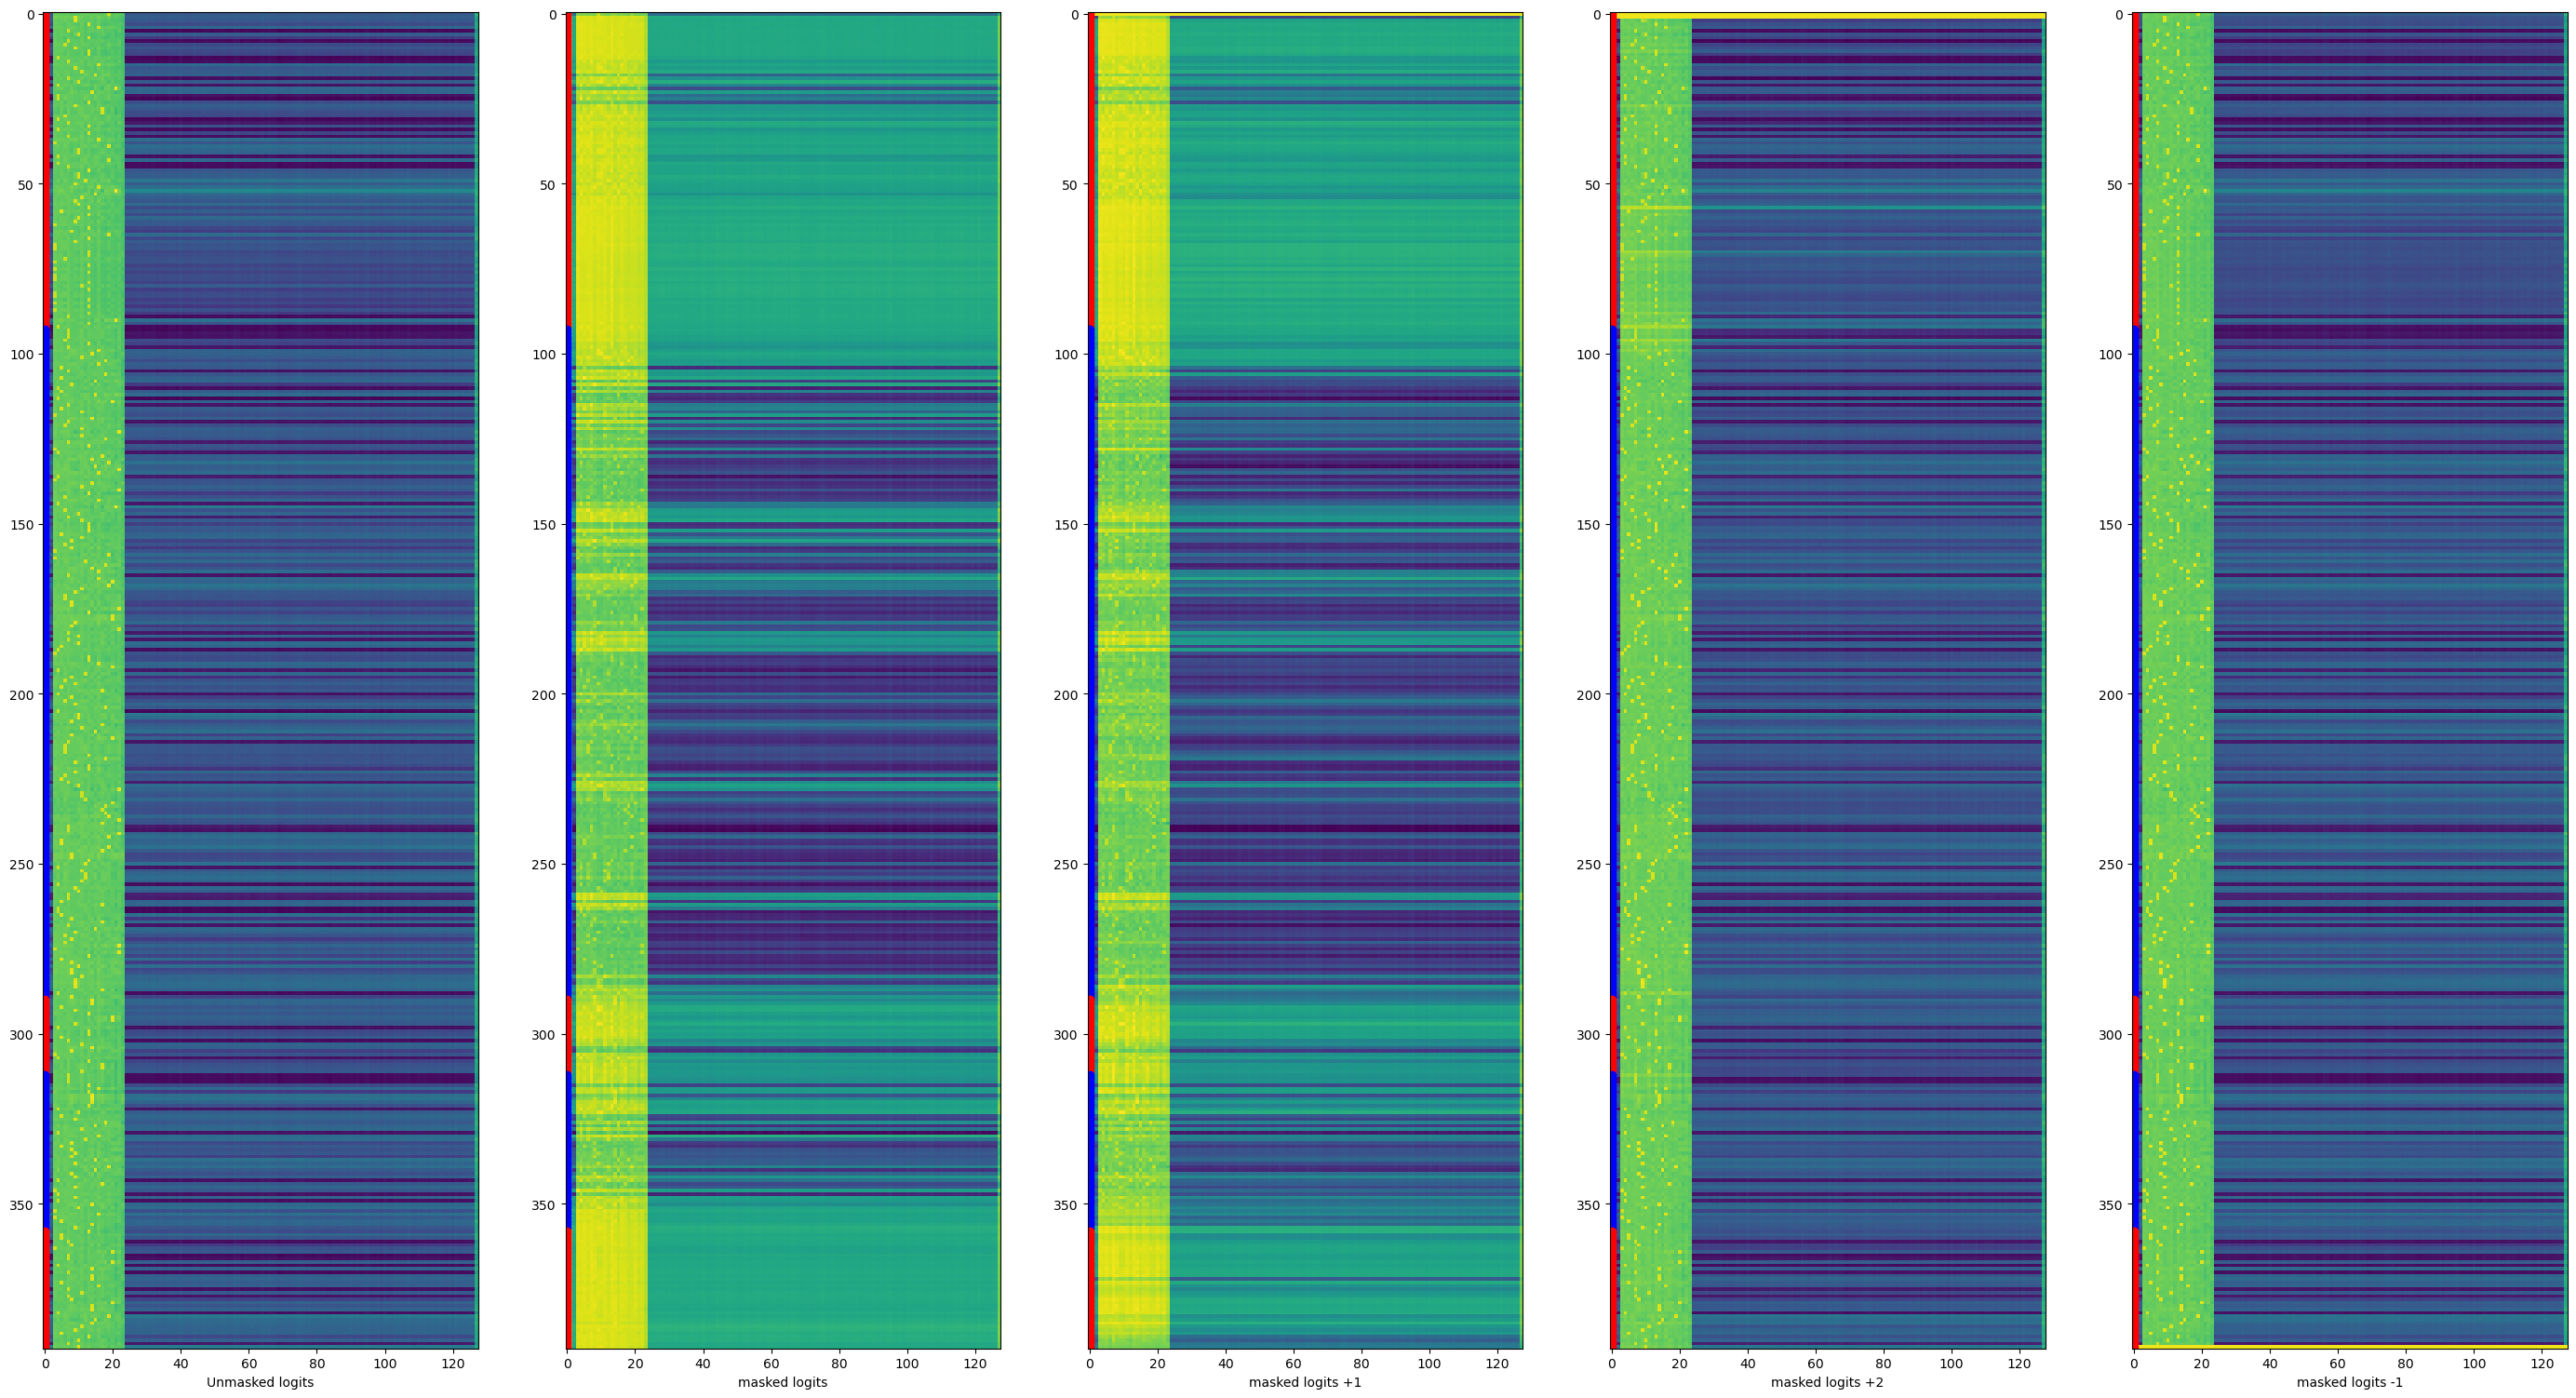

In [107]:

fig = plt.figure(figsize=(35,80))
ax1 = fig.add_subplot(151)
ax2 = fig.add_subplot(152)
ax3 = fig.add_subplot(153)
ax4 = fig.add_subplot(154)
ax5 = fig.add_subplot(155)

ax1.imshow(t5_dict['unmasked_logits'].squeeze())
# add a line of color from aacolors
for i, color in enumerate(aa_colors):
    ax1.scatter(x=0, y=i, color=color)

# gather all aa-level losses into a single matrix
all_aalogits = []
all_aalogits_2 = []
all_aalogits2= [np.array([0]*128)]
all_aalogits3= [np.array([0]*128),np.array([0]*128)]
for i in range(len(prot_tokens)):
    all_aalogits.append(np.array(t5_dict['aamask_1']['logits'][i][i]))
    if i+1 < len(prot_tokens):
        all_aalogits2.append(np.array(t5_dict['aamask_1']['logits'][i][i+1]))
    if i+2 < len(prot_tokens):
        all_aalogits3.append(np.array(t5_dict['aamask_1']['logits'][i][i+2]))
    if i-1 >= 0:
        all_aalogits_2.append(np.array(t5_dict['aamask_1']['logits'][i][i-1]))
all_aalogits_2.append(np.array([0]*128))


all_aalogits = np.array(all_aalogits)

ax2.imshow(all_aalogits)
ax3.imshow(all_aalogits2)
ax4.imshow(all_aalogits3)
ax5.imshow(all_aalogits_2)
for i, color in enumerate(aa_colors):
    ax2.scatter(x=0, y=i, color=color)
    ax3.scatter(x=0, y=i, color=color)
    ax4.scatter(x=0, y=i, color=color)
    ax5.scatter(x=0, y=i, color=color)
ax1.set_xlabel("Unmasked logits")
ax2.set_xlabel("masked logits")
ax3.set_xlabel("masked logits +1")
ax4.set_xlabel("masked logits +2")
ax5.set_xlabel("masked logits -1")
plt.show()


In [102]:
for e in all_aalogits2:
    print(len(e))

393
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128


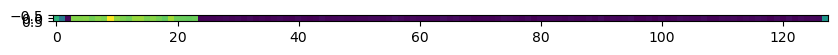

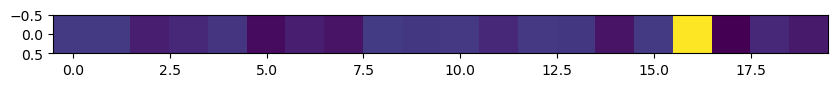

In [56]:
import matplotlib.pyplot as plt

i=0
j=0
logitsij = np.expand_dims(logits[i][j], axis=0)

plt.figure(figsize=(10,3))
plt.imshow(logitsij)
plt.show()

unmasked_logits = t5_dict['unmasked_logits'].squeeze()[:,T5_vocab_ix]

plt.figure(figsize=(10,3))
plt.imshow(np.expand_dims(unmasked_logits[j], axis=0))
plt.show()

In [54]:
unmasked_logits[j]

tensor([-22.1682, -22.1638, -23.9368, -23.3988, -22.5226, -25.1324, -23.9490,
        -24.6721, -21.9753, -22.3435, -22.2093, -23.2862, -22.1850, -22.2779,
        -24.6375, -22.1425,  -4.4528, -25.7614, -23.2710, -24.2061])

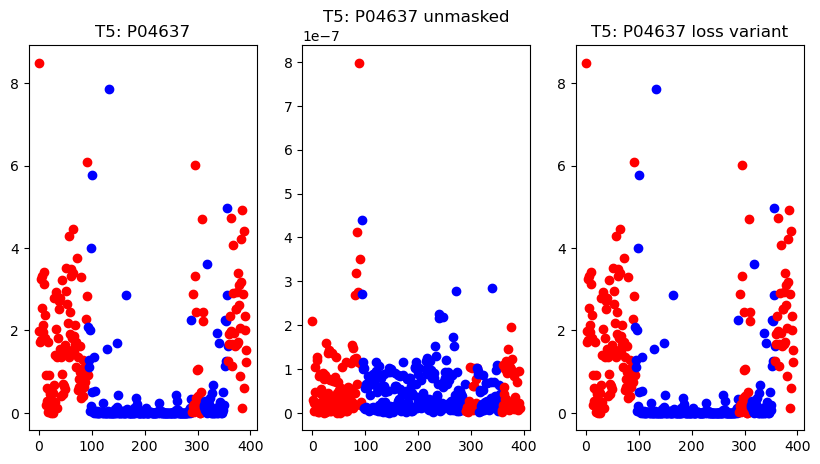

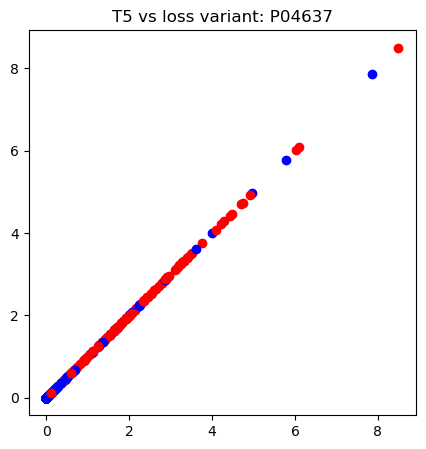

In [50]:
# plot the aa-level losses
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

for i in range(L):
    ax1.scatter( i , T5_aaloss_sequences[i][i], c=aa_colors[i])
    ax1.set_title(f"T5: {uniprot_id}")
    ax2.scatter( i , T5_unmasked_aaloss_sequence[i], c=aa_colors[i])
    ax2.set_title(f"T5: {uniprot_id} unmasked")
    ax3.scatter( i , all_loss_sequences[i][i], c=aa_colors[i])
    ax3.set_title(f"T5: {uniprot_id} loss variant")
plt.show()


# plot T5 vs loss variant
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)
for i in range(L):
    ax1.scatter( T5_aaloss_sequences[i][i], all_loss_sequences[i][i], c=aa_colors[i])
ax1.set_title(f"T5 vs loss variant: {uniprot_id}")
plt.show()





In [37]:
print(len(datadict[uniprot_id]['disorder']))
print(len(datadict[uniprot_id]['seq']))
print(uniprot_id)

736
736
O00522
